## Part 3: Modelling & Predicting Pneumonia w/ Neural Networks

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/capstone"

/content/drive/MyDrive/capstone


In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [ ]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"

# Read labels and classinfo
labels = pd.read_csv(labelsPath)
details = pd.read_csv(classInfoPath)

## Part 3.1: Attaining our Training & Testing Data in Proper Format

In [ ]:
"""
@Description: Reads an array of dicom image paths, and returns an array of the images after they have been read

@Inputs: An array of filepaths for the images

@Output: Returns an array of the images after they have been read
"""
def readDicomData(data):
    
    res = []
    
    for filePath in tqdm(data): # Loop over data
        
        # Using stop_before_pixels to avoid reading the image (Saves on speed/memory)
        f = pydicom.read_file(filePath, stop_before_pixels=True)
        res.append(f)
    
    return res

In [ ]:
# Creating an array of the test & training file paths
trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

# Reading data into an array
trainImages = readDicomData(trainFilepaths[:5000])
testImages = readDicomData(testFilepaths[:3000])

100%|██████████| 3000/3000 [12:12<00:00,  4.10it/s]


## Part 3.2: Balancing our Data

We balance our data as CNNs work best on evenly balanced data

In [ ]:
COUNT_NORMAL = len(labels.loc[labels['Target'] == 0]) # Number of patients with no pneumonia
COUNT_PNE = len(labels.loc[labels['Target'] == 1]) # Number of patients with pneumonia
TRAIN_IMG_COUNT = len(trainFilepaths) # Total patients

# Calculating the weight of each
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNE)*(TRAIN_IMG_COUNT)/2.0

classWeight = {0: weight_for_0, 
               1: weight_for_1}

print(f"Weights: {classWeight}")

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


## Part 3.3: Get Train_Y & Test_Y

In [ ]:
"""
@Description: This function parses the medical images meta-data contained

@Inputs: Takes in the dicom image after it has been read

@Output: Returns the unpacked data and the group elements keywords
"""
def parseMetadata(dcm):
    
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm: # Iterating to force conversion from lazy RawDataElement to DataElement
        pass
    
    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords

In [ ]:
# Parsing metadata into dictionaries
trainMetaDicts, trainKeyword = zip(*[parseMetadata(x) for x in tqdm(trainImages)])
testMetaDicts, testKeyword = zip(*[parseMetadata(x) for x in tqdm(testImages)])

100%|██████████| 3000/3000 [00:03<00:00, 862.77it/s] 


In [ ]:
"""
@Description: This function goes through the dicom image information and returns 1 or 0
              depending on whether the image contains Pneumonia or not

@Inputs: A dataframe containing the metadata

@Output: Returns the Y result (i.e: our train and test y)
"""
def createY(df):
    y = (df['SeriesDescription'] == 'view: PA')
    Y = np.zeros(len(y)) # Initialise Y
    
    for i in range(len(y)):
        if(y[i] == True):
            Y[i] = 1
    
    return Y


train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

df = train_df
df2 = test_df

train_Y = createY(df) # Create training Y 
test_Y = createY(df2) # Create testing Y

## Part 3.4: Get Train_X & Test_X

In [ ]:
"""
@Description: This decodes an image by reading the pixel array, resizing it into the correct format and
              normalising the pixels

@Inputs:
    - filePath: This is the filepath of the image that we want to decode

@Output:
    - img: This is the image after it has been decoded
"""
def decodeImage(filePath):
    image = pydicom.read_file(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return (image/255)

In [ ]:
# Get our train x in the correct shape
train_X = []

for filePath in tqdm(trainFilepaths[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [00:58<00:00, 85.97it/s]


In [ ]:
# Get our test x in the correct shape for NN
test_X = []

for filePath in tqdm(testFilepaths):
    img_test = decodeImage(filePath) # Decode & Resize
    test_X.append(img_test)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:34<00:00, 86.19it/s]


In [ ]:
"""
@Description: This function plots our metrics for our models across epochs

@Inputs: The history of the fitted model

@Output: N/A
"""
def plottingScores(hist):
    fig, ax = plt.subplots(1, 5, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

## Part 3.5: Metrics Evaluation
For our metrics, we want to include <b><i>precision</i></b> and <b><i>recall</i></b> as they will provide use with more info on how good our model is
 
 
- <b><u>Accuracy:</u></b> This tells us what fraction of the labels are correct.
    - Since our data is not balanced, accuracy might give a skewed sense of a good model


- <b><u>Precision:</u></b> This tells us the number of true positives (TP) over the sum of TP and false positives (FP). 
    - It shows what fraction of labeled positives are actually correct.


- <b><u>Recall:</u></b> The number of TP over the sum of TP and false negatves (FN). 
    - It shows what fraction of actual positives are correct.

In [ ]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

### Tuning our Models with Callbacks

- We'll use Keras callbacks to further finetune our model. 
- The <b>checkpoint callback</b> saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. 
- The <b>early stopping callback</b> stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. 
- Since we set restore_best_weights to True, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [ ]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

## Part 3.6: Building Model #1 - Fully Connected Model

In [ ]:
"""
@Description: This function builds our simple Fully-connected NN

@Inputs: N/A

@Output: Returns the FCNN Model
"""
def build_fcnn_model():
    
    # Basic model with a flattening layer followng by 2 dense layers
    # The first dense layer is using relu and the 2nd one is using sigmoid
    model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape = (128, 128, 3)), 
                tf.keras.layers.Dense(128, activation = "relu"), 
                tf.keras.layers.Dense(1, activation = "sigmoid")
                ])
    
    return model

In [ ]:
# Building our FCNN model and compile
model_fcnn = build_fcnn_model()
model_fcnn.summary()
model_fcnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS) # Compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________


### Fitting Model to Training Data

In [ ]:
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30,
                          batch_size = 128,
                          validation_split = 0.2, 
                          class_weight = classWeight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit the model

Epoch 1/30
32/32 [==============================] - 1s 35ms/step - loss: 0.2036 - accuracy: 0.9103 - precision: 0.8935 - recall: 0.9500 - AUC: 0.9718 - val_loss: 0.2231 - val_accuracy: 0.9260 - val_precision: 0.9652 - val_recall: 0.8922 - val_AUC: 0.9703 - lr: 0.0100
Epoch 2/30
32/32 [==============================] - 1s 30ms/step - loss: 0.2194 - accuracy: 0.8997 - precision: 0.8799 - recall: 0.9468 - AUC: 0.9679 - val_loss: 0.2154 - val_accuracy: 0.9210 - val_precision: 0.9018 - val_recall: 0.9546 - val_AUC: 0.9801 - lr: 0.0089
Epoch 3/30
32/32 [==============================] - 2s 78ms/step - loss: 0.1839 - accuracy: 0.9145 - precision: 0.8929 - recall: 0.9595 - AUC: 0.9785 - val_loss: 0.2110 - val_accuracy: 0.9280 - val_precision: 0.9770 - val_recall: 0.8847 - val_AUC: 0.9767 - lr: 0.0079
Epoch 4/30
32/32 [==============================] - 1s 30ms/step - loss: 0.1833 - accuracy: 0.9193 - precision: 0.9046 - recall: 0.9536 - AUC: 0.9775 - val_loss: 0.2242 - val_accuracy: 0.9100 - va

94/94 [==============================] - 1s 8ms/step - loss: 0.1902 - accuracy: 0.9387 - precision: 0.9410 - recall: 0.9456 - AUC: 0.9797
{'loss': 0.19015023112297058, 'accuracy': 0.9386666417121887, 'precision': 0.9409593939781189, 'recall': 0.9456118941307068, 'AUC': 0.9796670079231262}


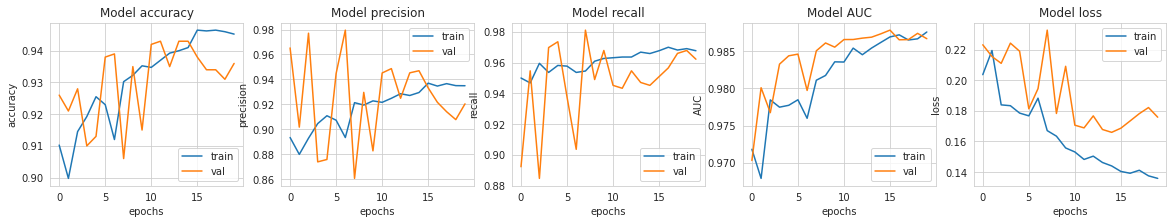

In [ ]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plottingScores(history_fcnn) # Visualise scores

## Part 3.7: Building Model #2 - CNN

In our CNN model, fewer parameters are needed because every convolutional layer reduces the dimensions of the input through the convolution operation.

In [ ]:
"""
@Description: This function builds our custom CNN Model

@Inputs: N/A

@Output: Returns the CNN model
"""
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(128, 128, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [ ]:
# Building and compiling model
model_cnn = build_cnn_model()
model_cnn.summary()
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=30, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classWeight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                      verbose=1) # Fit the model

Epoch 1/30
34/34 [==============================] - 6s 176ms/step - loss: 0.1398 - accuracy: 0.9424 - precision: 0.9316 - recall: 0.9657 - AUC: 0.9852 - val_loss: 1.2117 - val_accuracy: 0.7680 - val_precision: 0.9912 - val_recall: 0.5678 - val_AUC: 0.9022 - lr: 0.0100
Epoch 2/30
34/34 [==============================] - 6s 169ms/step - loss: 0.1041 - accuracy: 0.9553 - precision: 0.9451 - recall: 0.9751 - AUC: 0.9914 - val_loss: 0.6969 - val_accuracy: 0.8107 - val_precision: 0.9706 - val_recall: 0.6633 - val_AUC: 0.9240 - lr: 0.0089
Epoch 3/30
34/34 [==============================] - 6s 167ms/step - loss: 0.0754 - accuracy: 0.9704 - precision: 0.9646 - recall: 0.9820 - AUC: 0.9948 - val_loss: 0.7756 - val_accuracy: 0.7107 - val_precision: 0.6558 - val_recall: 0.9573 - val_AUC: 0.8844 - lr: 0.0079
Epoch 4/30
34/34 [==============================] - 6s 166ms/step - loss: 0.0815 - accuracy: 0.9659 - precision: 0.9565 - recall: 0.9824 - AUC: 0.9940 - val_loss: 0.7644 - val_accuracy: 0.7467 

94/94 [==============================] - 2s 22ms/step - loss: 0.1554 - accuracy: 0.9480 - precision: 0.9873 - recall: 0.9153 - AUC: 0.9911
{'loss': 0.15537382662296295, 'accuracy': 0.9480000138282776, 'precision': 0.987333357334137, 'recall': 0.9153275489807129, 'AUC': 0.9910994172096252}


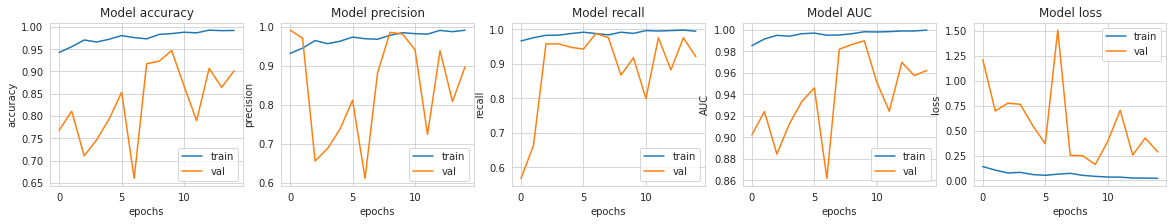

In [ ]:
# Evaluating models results and put them into a dict
results = model_cnn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_cnn.metrics_names,results))

print(results)
plottingScores(history_cnn) # Visualise scores

## Part 3.8: Building Model #3 - Mobile Net with Transfer Learning

In [ ]:
"""
@Description: This function builds our MobileNet Model

@Inputs: N/A

@Output: Returns the Mobile Net model
"""
def build_mn_model():
    
    model = tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.layers[0].trainable = False
    
    return model

In [ ]:
# Building and compiling mobile net model
model_mn = build_mn_model()
model_mn.summary()
model_mn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_mn = model_mn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30, 
                          validation_split = 0.20, 
                          class_weight = classWeight,
                          batch_size = 64,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/30
63/63 [==============================] - 16s 180ms/step - loss: 0.2324 - accuracy: 0.8985 - precision: 0.9228 - recall: 0.9306 - AUC: 0.9752 - val_loss: 0.0689 - val_accuracy: 0.9780 - val_precision: 0.9738 - val_recall: 0.9849 - val_AUC: 0.9969 - lr: 0.0100
Epoch 2/30
63/63 [==============================] - 7s 117ms/step - loss: 0.0509 - accuracy: 0.9793 - precision: 0.9736 - recall: 0.9891 - AUC: 0.9981 - val_loss: 0.0526 - val_accuracy: 0.9820 - val_precision: 0.9794 - val_recall: 0.9868 - val_AUC: 0.9981 - lr: 0.0089
Epoch 3/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0354 - accuracy: 0.9872 - precision: 0.9851 - recall: 0.9918 - AUC: 0.9990 - val_loss: 0.0593 - val_accuracy: 0.9820 - val_precision: 0.9723 - val_recall: 0.9943 - val_AUC: 0.9975 - lr: 0.0079
Epoch 4/30
63/63 [==============================] - 8s 121ms/step - loss: 0.0274 - accuracy: 0.9925 - precision: 0.9896 - recall: 0.9968 - AUC: 0.9993 - val_loss: 0.0498 - val_accuracy: 0.9870

94/94 [==============================] - 5s 50ms/step - loss: 0.0538 - accuracy: 0.9870 - precision: 0.9858 - recall: 0.9901 - AUC: 0.9963
{'loss': 0.0538092665374279, 'accuracy': 0.9869999885559082, 'precision': 0.9858461618423462, 'recall': 0.990111231803894, 'AUC': 0.9962998032569885}


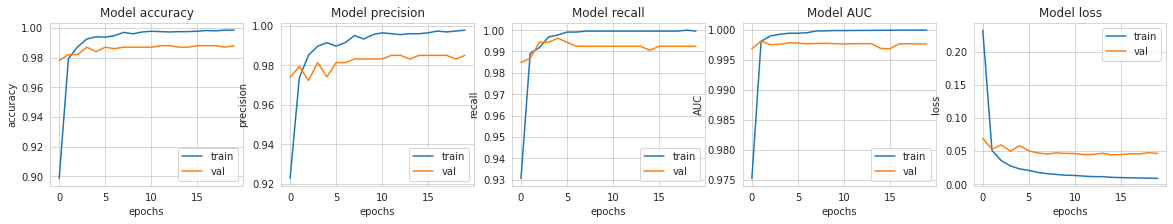

In [ ]:
# Show results and print graphs
results = model_mn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_mn.metrics_names,results))

print(results)
plottingScores(history_mn) # Visualise scores

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model_mn.predict_classes(test_X_rgb)
confusion_matrix(test_Y, y_pred)

AttributeError: ignored

### Function to Perform K-Fold CV

In [ ]:
import gc

In [ ]:
"""
@Description: This function performs K-Fold Cross Validation with a provided Deep Learning Model

@Inputs:
    - K: Number of folds
    - build_model_func: Function to create model
    - epochs: Number of epochs to train data
    - batchSize: Batch size when fitting the model

@Output: Dict of metric results from K-fold CV
"""
def performCV(K, build_model_func, epochs, batchSize):
    
    kfold = KFold(n_splits = K, shuffle = True) # Split data into K Folds
    
    res = {
        'acc_per_fold': [],
        'precision_per_fold': [],
        'recall_per_fold': [],
        'auc_per_fold': [],
        'loss_per_fold': []
    }

    fold_no = 1

    for train_index, test_index in kfold.split(train_X_rgb):

        X_train, X_test = train_X_rgb[train_index], train_X_rgb[test_index] # Split data
        y_train, y_test = train_Y[train_index], train_Y[test_index]

        model = build_model_func() # Build model
        mets = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='AUC')]

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=mets) # Compile our model

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Train the model on the current fold
        history = model.fit(X_train,
                            y_train, 
                            epochs = epochs,
                            batch_size = batchSize,
                            class_weight = classWeight,
                            callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit data to model

        scores = model.evaluate(X_test, y_test, verbose=0) # Evalute the model

        print(f'Scores for fold {fold_no}:')
        print(f'{model.metrics_names[0]}: {scores[0]}')
        print(f'{model.metrics_names[1]}: {scores[1]*100}%')
        print(f'{model.metrics_names[2]}: {scores[2]*100}%')
        print(f'{model.metrics_names[3]}: {scores[3]*100}%')

        res['loss_per_fold'].append(scores[0])
        res['acc_per_fold'].append(scores[1] * 100)
        res['precision_per_fold'].append(scores[2]*100)
        res['recall_per_fold'].append(scores[3]*100)
        res['auc_per_fold'].append(scores[4]*100)

        gc.collect()
        # Increase fold number
        fold_no += 1
    
    return res # return our results dict

## Part 3.9: K-Fold Cross Validation with all 3 Networks

In [ ]:
# Full-connected NN
resFCNN = performCV(5, build_fcnn_model, 30, 128)

In [ ]:
# Convolutional NN
resCNN = performCV(5, build_cnn_model, 30, 64)

In [ ]:
# MobileNet
resMB = performCV(5, build_mn_model, 30, 64)

In [ ]:
resMB